# Create and run a local RAG from scratch

## What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal is to take information and pass it to LLM so it can generate output based on that information

* Retrieval - Find relevant information given a query, e.g. "What are the macronutrients and what do they do?" -> retrieves passage of text related to the macronutrients from a nutrition textbook.
* Augmented - Take the relevant information and augment the input (prompt) to an LLM with that relevant information.
* Generation - Take the first two steps and pass them to an LLM for generative outputs.

Read paper about RAG from Facebook: https://arxiv.org/abs/2005.11401

## Why RAG?

the main goal of RAG is to improve the generation output of LLMs.

1. Prevent hallucinations - RAG help LLMs to generate factual information.
2. Work with custom data - Normally LLMs were trained on general data on the internet.

## What can RAG be used for?

* Customer support Q&A chat - Treat existing customer support documents as a resource when a customer asks a question. Like a chat bot for the documentation
* Email chain analysis - Large insurance company with chains of emails of customer claims could use RAG to find relevant information from those emails and then use an LLM to process that information into structured data.
* Company internal documentation chat.
* Textbook Q&A - Nutrition students with 1200 pages of texbook could build a RAG pipeline to go through the textbook and find relevant passages to the questions.

Common theme: take relevant documents to a query and process them with an LLM.

## Why local?

Privacy, speed, and cost.

* Privacy - Each companies have private information the don't want to share to an API.
* Speed - Data travel through API takes time.
* Cost - No need to pay for API.
* No vendor lockin - If OpenAI/LLMs company shutdown, business could still be running on its own.

## What will be build

sources: https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

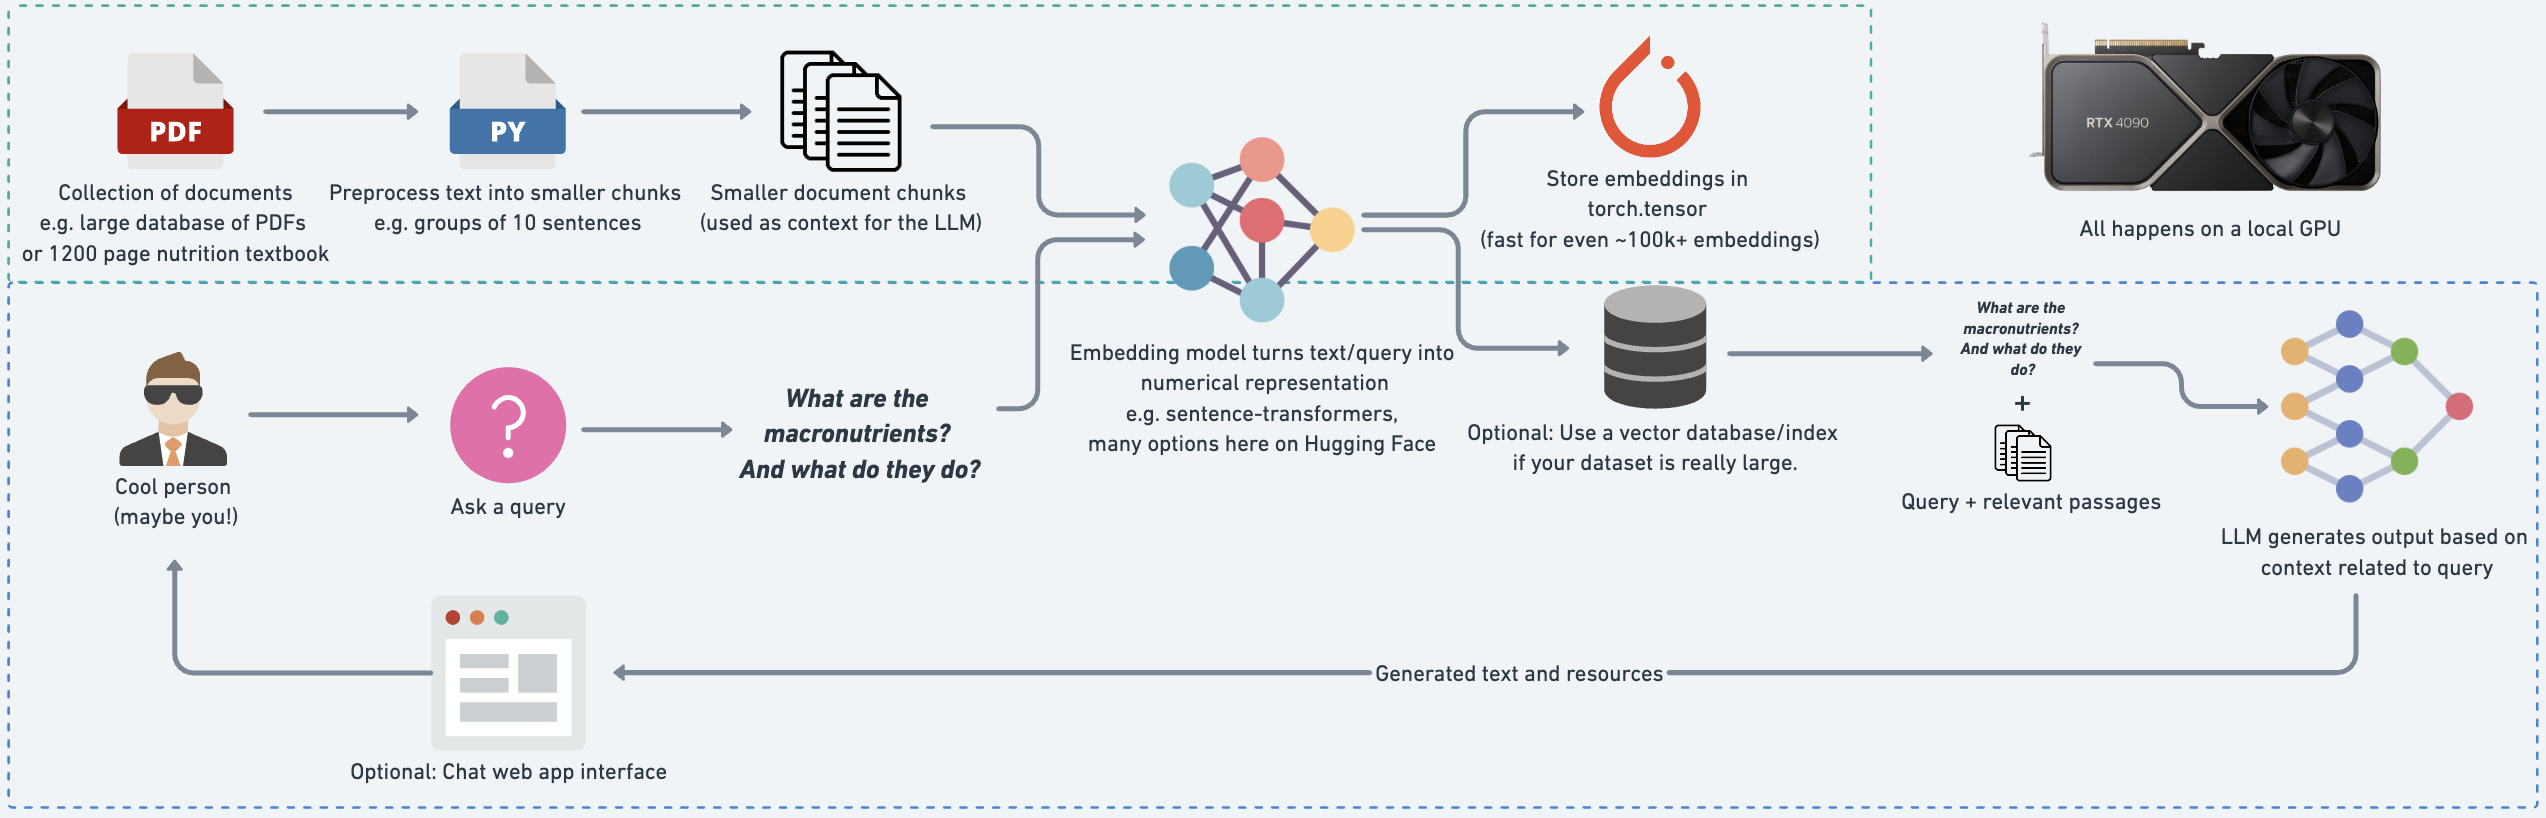

Build Nutrichat to "chat with nutrition textbook".

Specifically:

1. Open a PDF documents.
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical representations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

Major steps:
1. Steps 1-3: Document preprocessing and embedding creation.
2. Steps 4-6: Search and answer.

## 1. Document/text processing and embedding creation.

Ingredients:
* PDF/text documents of choice
* Embedding model of choice

Steps:
1. Import PDF documents.
2. Process text for embeddings (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later.

### Import PDF document

In [1]:
import os
import requests

# Get PDF document path
pdf_path = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")

    # URL of file
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # Send GET request
    response = requests.get(url)

    # Check status code
    if response.status_code == 200:
        # Save file
        with open(pdf_path, "wb") as file:
            file.write(response.content)
        print(f"[INFO] File downloaded and saved as {pdf_path}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
else:
    print(f"[INFO] {pdf_path} already exist")

[INFO] human-nutrition-text.pdf already exist


In [2]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Perform minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # More text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str, first_page=0) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({
            "page_number": page_number - first_page, # pdf actual content starts on page 43. in index its 42, substract it with 41 and its become page 1 in dictionary
            "page_char_count": len(text),
            "page_word_coount": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4, # 1 token = ~ 4 characters. see https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
            "text": text,
        })
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path, first_page=41)
pages_and_texts[:2]

/opt/miniconda3/envs/ai-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1208it [00:01, 804.56it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_coount': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_coount': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 257,
  'page_char_count': 580,
  'page_word_coount': 108,
  'page_sentence_count_raw': 4,
  'page_token_count': 145.0,
  'text': 'Image by  Forluvoft /  Public  Domain  Sparing Protein  In a situation where there is not enough glucose to meet the body’s  needs, glucose is synthesized from amino acids. Because there is  no storage molecule of amino acids, this process requires the  destruction of proteins, primarily from muscle tissue. The presence  of adequate glucose basically spares the breakdown of proteins  from being used to make glucose needed by the body.  Lipid Metabolism  As blood-glucose levels rise, the use of lipids as an energy source is  The Functions of Carbohydrates in the Body  |  257'},
 {'page_number': 1049,
  'page_char_count': 1841,
  'page_word_coount': 318,
  'page_sentence_count_raw': 16,
  'page_token_count': 460.25,
  'text': 'Instead, the food is broken down in the intestines only.) Medical  foods are created to meet very specific nutritional

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_coount,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_coount,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why should care about token count?

Token count is important because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html).

As for LLMs, they can't accept infinite tokens in their context window.

### Further text processing (splitting pages into sentences)

Two ways to do this:
1. Splitting on `". "` (done this on above).
2. Using NLP library such as spaCy and nltk.

In [6]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
nlp.add_pipe('sentencizer')

# Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. I like sushi.")
assert len(list(doc.sents)) == 3

# Print out sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like sushi.]

In [7]:
for item in tqdm(pages_and_texts):
    item['sentences'] = list(nlp(item['text']).sents)

    # Make sure all the sentences are strings (the default type is a spaCy datatype)
    item['sentences'] = [str(sentences) for sentences in item['sentences']]

    # Count the sentences
    item['page_sentence_count_spacy'] = len(item['sentences'])

100%|██████████| 1208/1208 [00:01<00:00, 1128.16it/s]


In [8]:
random.sample(pages_and_texts, k=1)

[{'page_number': 638,
  'page_char_count': 995,
  'page_word_coount': 225,
  'page_sentence_count_raw': 2,
  'page_token_count': 248.75,
  'text': 'Food  Serving  Methionine  (mg)  Cystine  (mg)  Turkey breast  1 breast  7102  2442  Brazil nuts  1 cup  1495  407  Canned tuna  1 cup  1259  456  Swiss Cheese,  diced  1 cup  1035  383  Canned green  peas  1 can  257  0.172  Egg, whole  1 large  189  136  Dried peaches  1 cup  139  46  Sweet potatoes  1 cup  134  43  Russet potatoes,  baked  1 large potato (3” to 4-¼”  diameter)  123  93  Whole-grain  bread  1 slice  36  46  Broccoli  ½ cup  34  24  Cauliflower  ½ cup  16  13  Source: USDA Standard Reference Legacy Nutrient Search  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Ope

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_coount,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way to do this.

In this example split into groups of 10 sentences.

There are frameworks such as LangChain which can help with this: https://python.langchain.com/docs/concepts/text_splitters/

Why do chunking:
1. Texts are easier to filter (smaller groups of text can be easier to inspect than larger passages of text).
2. Text chunks can fit into embedding model context window (e.g. 384 token as a limit).
3. Context passed to an LLM can be more specific and focused.

In [10]:
# Define split size to turn group of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. list of [20] -> [10, 10] or [25] -> [10, 10, 5]

def split_list(input_list: list[str], slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

In [11]:
test_list = list(range(25))

split_list(test_list, num_sentence_chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item['sentence_chunks'] = split_list(item['sentences'], slice_size=num_sentence_chunk_size)

    item['num_chunks'] = len(item['sentence_chunks'])

100%|██████████| 1208/1208 [00:00<00:00, 776389.71it/s]


In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 573,
  'page_char_count': 1112,
  'page_word_coount': 189,
  'page_sentence_count_raw': 11,
  'page_token_count': 278.0,
  'text': 'making it unavailable for absorption. A rare genetic disease-causing  malfunction of the biotinidase enzyme also results in biotin  deficiency. Symptoms of biotin deficiency are similar to those of  other B vitamins, but may also include hair loss when severe.  Dietary Reference Intakes  Because there is little information on the requirements for biotin,  the FNB has developed Adequate Intakes (AI) based on the observed  dietary intakes in healthy population groups. The AI for different age  groups for biotin are listed in Table 9.21 “Dietary Reference Intakes  for Biotin”.  Table 9.21 Dietary Reference Intakes for Biotin  Age Group  AI Males and Females mcg/day)  Infants (0–6 months)  5  Infants (7–12 months)  6  Children (1–3 years)  8  Children (4–8 years)  12  Children (9–13 years)  20  Adolescents (14–18 years) 25  Adults (> 19 years)

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_coount,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

Each chunk of sentences will be embed into its own numerical representation.

That will give a good level of granularity.

Meaning, easier to dive specifically into the text sample in the model

In [15]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        # Join the sentences together into a paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub('\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A"

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        # Get some stats
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len(joined_sentence_chunk.split(" "))
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token ~= 4 chars

        pages_and_chunks.append(chunk_dict)
len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 30391.32it/s]


1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1048,
  'sentence_chunk': 'Check with a health professional regarding the effects of modified foods on your health. Medical foods are designed for enteric administration under the guidance of a medical professional. (During enteric administration, food is treated so that it goes through the stomach undigested. 2.\xa0Functional Foods. The Academy of Nutrition and Dietetics.https://www.eatright.org/food/nutrition/ healthy-eating/functional-foods. Published July 5, 2018. Accessed April 15, 2018. 1048 | Comparing Diets',
  'chunk_char_count': 490,
  'chunk_word_count': 63,
  'chunk_token_count': 122.5}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [18]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


### Filter chunks of text for short chunks

These chunks may not contain much useful information

In [19]:
# Show random chunks with under 30 tokens in length
min_token_length = 30

for row in df[df['chunk_token_count'] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text : {row[1]['sentence_chunk']}") # index 0 is index, 1 is series

Chunk token count: 28.75 | Text : Accessed September 22, 2017. Dietary, Behavioral, and Physical Activity Recommendations for Weight Management | 507
Chunk token count: 27.5 | Text : Figure 15.1 reused “Silohuette of Three People” by photo- nic.co.uk nic / Unsplash License 1158 | Attributions
Chunk token count: 3.25 | Text : 814 | Infancy
Chunk token count: 19.25 | Text : 2018). Centers for Disease Control and 998 | The Causes of Food Contamination
Chunk token count: 20.5 | Text : http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=118   132 | The Immune System


In [20]:
# Filter dataframe with rows under 30 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [21]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 738,
  'sentence_chunk': 'Eating smaller meals will diminish the size of your appetite over time so you will feel satisfied with smaller amounts of food. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: 738 | Discovering Nutrition Facts',
  'chunk_char_count': 812,
  'chunk_word_count': 124,
  'chunk_token_count': 203.0}]

### Embedding text chunks

Embeddings are a broad but powerful concept.

While humans understand texts, machine understand numbers.

For a great resources on learning embeddings, see https://vickiboykis.com/what_are_embeddings/

In [22]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2', device="cpu")

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings",
             "Sentences can be embedded one by one or in a list.",
             "I like sushi!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}\n")

Sentence: The Sentence Transformer library provides an easy way to create embeddings
Embedding: [-3.17512602e-02  3.37267593e-02 -2.52438001e-02  5.22288382e-02
 -2.35249568e-02 -6.19115820e-03  1.35025773e-02 -6.25500605e-02
  7.50829047e-03 -2.29685046e-02  2.98145413e-02  4.57555540e-02
 -3.26700620e-02  1.39846522e-02  4.18013185e-02 -5.92970066e-02
  4.26310152e-02  5.04657300e-03 -2.44552754e-02  3.98594653e-03
  3.55898365e-02  2.78742723e-02  1.84098538e-02  3.67699973e-02
 -2.29961928e-02 -3.01796887e-02  5.99622435e-04 -3.64504568e-02
  5.69105037e-02 -7.49932509e-03 -3.70004326e-02 -3.04358592e-03
  4.64354306e-02  2.36154743e-03  9.06849209e-07  7.00042909e-03
 -3.92289273e-02 -5.95702697e-03  1.38653936e-02  1.87098887e-03
  5.34202866e-02 -6.18613176e-02  2.19613630e-02  4.86051217e-02
 -4.25697267e-02 -1.69858783e-02  5.04178144e-02  1.54734440e-02
  8.12859535e-02  5.07106185e-02 -2.27496829e-02 -4.35721166e-02
 -2.18394632e-03 -2.14091279e-02 -2.01757774e-02  3.0683197

In [23]:
print("How similar each sentences:")
print(f'sentence 1 and 2: {embedding_model.similarity(embeddings[0], embeddings[1])}')
print(f'sentence 1 and 3: {embedding_model.similarity(embeddings[0], embeddings[2])}')
print(f'sentence 2 and 3: {embedding_model.similarity(embeddings[1], embeddings[2])}')

How similar each sentences:
sentence 1 and 2: tensor([[0.5425]])
sentence 1 and 3: tensor([[0.0125]])
sentence 2 and 3: tensor([[0.0426]])


In [24]:
embeddings[0].shape

(768,)

In [25]:
embedding = embedding_model.encode('My favourite animal is the cow!')
embedding

array([-1.45474104e-02,  7.66726434e-02, -2.85871755e-02, -3.31282876e-02,
        3.65210250e-02,  4.78570387e-02, -7.08107725e-02,  1.62833799e-02,
        1.93443540e-02, -2.80482098e-02, -2.91747004e-02,  5.11309430e-02,
       -3.28720100e-02, -8.98757856e-03, -1.03672594e-02, -3.15488018e-02,
        4.22783643e-02, -9.13289376e-03, -1.94017719e-02,  4.35689427e-02,
       -2.31998321e-02,  4.29882854e-02, -1.72393154e-02, -2.01372635e-02,
       -3.13574299e-02,  8.08167085e-03, -2.06724983e-02, -2.27869581e-02,
        2.44812556e-02,  1.71968248e-02, -6.26672879e-02, -7.54797608e-02,
        3.57421711e-02, -5.46558853e-03,  1.24730320e-06, -7.63201388e-03,
       -3.53221968e-02,  1.91326980e-02,  3.99046019e-02,  2.11733487e-03,
        1.64565388e-02,  9.84054897e-03, -1.80701278e-02,  9.33837239e-03,
        3.23482603e-02,  5.84785305e-02,  4.23187092e-02,  1.62091125e-02,
       -9.14910808e-02,  1.82305817e-02, -5.25731314e-03, -7.81024573e-03,
       -3.47643867e-02, -

In [26]:
%%time

embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

100%|██████████| 1680/1680 [03:04<00:00,  9.12it/s]

CPU times: user 10min 1s, sys: 1min 34s, total: 11min 36s
Wall time: 3min 4s


In [27]:
%%time

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 2.66 ms, sys: 2.13 ms, total: 4.79 ms
Wall time: 1.45 ms


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [28]:
len(text_chunks)

1680

In [29]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 11min 57s, sys: 2min 34s, total: 14min 32s
Wall time: 4min 1s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]])

In [30]:
text_chunk_embeddings.shape

torch.Size([1680, 768])

### Save embeddings to file

In [31]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [32]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [33]:
# Import saved file
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02280584e-02 -5.09552285e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52155972e-02 5.92137724e-02 -1.66167505e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801637e-02 3.39813568e-02 -2.06427071e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82567060e-02 3.81274000e-02 -8.46859720e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264121e-02 -8.49774759e-03 9.57154669e-...


If the embedding database is really large (e.g. over 100k-1M samples), might be better to look into using a vector database for storage: https://en.wikipedia.org/wiki/Vector_database

## 2. RAG - Search and Answer

RAG Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### Similarity search

Embeddings can be used for almost any type of data.

For example, image, sound, and text can be turned into embeddings.

Comparing embeddings is known as similarity search, vector search, and semantic search.

In this case, the goal is to query the nutrition textbook passages based on semantics or *vibe*.

So if "macronutrients functions" is searched then relevant passages to that text should be returned.

Whereas with keyword search, if "apple" were searched then the passages returned should be specifically "apple".

In [34]:
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings df and convert into dict
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to csv)
text_chunks_and_embeddings_df['embedding'] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)


# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902280584, -0.00509552285, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552155972, 0.0592137724, -0.0166167505, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801637, 0.0339813568, -0.0206427071, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.068256706, 0.0381274, -0.0084685972, -0.018..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264121, -0.00849774759, 0.00957154669, ..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25,"[0.018562289, -0.0164279286, -0.0127046434, -0..."
1676,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75,"[0.0334722362, -0.0570441522, 0.0151489442, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50,"[0.0770514011, 0.00978543423, -0.0121816965, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045091, -0.016470246, 0.00826844014, 0.0..."


In [35]:
embeddings.shape

torch.Size([1680, 768])

In [36]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device=device)

Embedding model ready!

Next create a semantic search pipeline.

In essence, search for a query (e.g. 'macronutrient function') and get back relevant passages from the textbook.

Steps:
1. Define a query.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity between the text embedding and the query embedding.
4. Sort the results from step 3 in descending order.

Note: to use dot product for comparison, ensure vectore sizes are of the same shape (e.g. 768) and tensors/vectors are in the same datatype (e.g. both are in torch.float32).

In [37]:
# 1. Define a query
query = "macronutrient functions"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's important to embed the query with the same model the passages embedded with
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity of outputs of models aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
[INFO] Time taken to get scores on 1680 embeddings: 0.00186 seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478]),
indices=tensor([42, 47, 46, 51, 41]))

In [38]:
# text_chunks_and_embeddings_df.iloc[42].sentence_chunk
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

Make the vector search results pretty

In [39]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [40]:
query = "macronutrient functions"
print(f"Query: {query}")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: macronutrient functions
Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are mole

Note: It's potentially possible to improve the order of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

See more:
- https://www.mixedbread.com/
- https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1

To check the results, it's possible to automatically surface the page of texts related to the query.

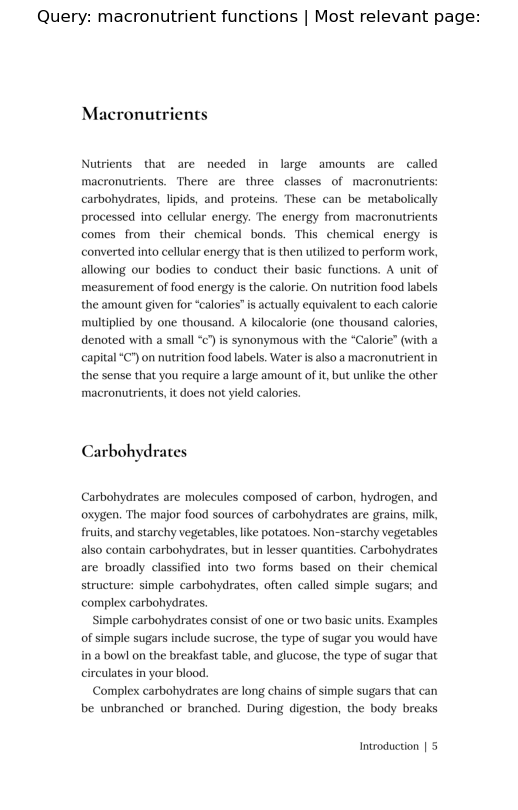

In [41]:
import fitz # pymupdf library

# Open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41) # note: the page numbers the PDF start at 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f'Query: {query} | Most relevant page:')
plt.axis('off')
plt.show()

### Similarity measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have direction (which way is it going) and magnitude (how long is it).

In [42]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate the dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print('')
# Calculate the cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)

Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing the semantic search pipeline

Put all the steps from above for semantic search into a function or two.

In [43]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor=embeddings,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    
    scores, indices = torch.topk(dot_scores, k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them out with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [44]:
query = "foods high in fiber"
# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings, pages_and_chunks=pages_and_chunks)

[INFO] Time taken to get scores on 1680 embeddings: 0.00052 seconds.
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than

### Getting an LLM for local generation

### Check Local GPU memory available

In [45]:
# Get GPU available memory
import torch

if torch.cuda.is_available():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"Available GPU memory: {gpu_memory_gb}GB")

In [46]:
# !nvidia-smi

### Loading an LLM locally

LLM can be load locally using Hugging Face `transformers`.

Model used: https://huggingface.co/google/gemma-2b-it

Things necessary to get a model running locally:
1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
2. A model ID - tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)
4. An LLM model - this will be used to generate text based on an input

> **NOTE:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2). See the github for more: https://github.com/Dao-AILab/flash-attention

In [75]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

use_quantization_config = False

# 1. Create a quantization config
# Note: required !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper, and above). See more: https://developer.nvidia.com/cuda-gpus
if is_flash_attn_2_available():
    attn_implementation = 'flash_attention_2'
else:
    attn_implementation = 'sdpa' # scaled dot product attention
print(attn_implementation)

# 2. Pick a model to use
# model_id = "google/gemma-2b-it"
# model_id = "Qwen/Qwen3-0.6B-Base"
model_id = "Qwen/Qwen2.5-0.5B-Instruct"

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory
                                                 device_map='auto',
                                                 attn_implementation=attn_implementation)

llm_model.to(device)

sdpa


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [76]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

494032768

In [78]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {
        "model_mem_bytes": model_mem_bytes,
        "model_mem_mb": round(model_mem_mb, 2),
        "model_mem_gb": round(model_mem_gb, 2),
    }

get_model_mem_size(llm_model)

{'model_mem_bytes': 988065664, 'model_mem_mb': 942.29, 'model_mem_gb': 0.92}

### Generate text with LLM 

In [84]:
prompt = "What are macronutrients and what role do they play in the body"
messages = [{"role": "user", "content": prompt}]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

model_inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)

generated_ids = llm_model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

Macronutrients are essential nutrients that your body needs to function properly. They include carbohydrates, proteins, fats, vitamins, and minerals. These nutrients work together to provide energy, support bodily functions, and maintain overall health.

Carbohydrates are one of the three main macronutrients and serve as an immediate source of energy for the brain and muscles. Carbs are found primarily in foods like bread, pasta, rice, fruits, vegetables, and some dairy products.

Proteins are another type of macronutrient and are crucial for growth, repair, and maintenance of tissues throughout the body. Proteins can be found in various sources such as meat, fish, poultry, eggs, beans, lentils, nuts, and seeds.

Fats are important for energy production and cell membrane structure. Fats come from animal-based foods like butter, cheese, and fatty fish. Fatty acids also play a role in hormone production and cellular signaling.

Vitamins are water-soluble nutrients that our bodies cannot 

In [85]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created questions
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins."
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins.']

In [86]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.03984 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128]),
 tensor([ 51,  47, 874,  41, 927]))

### Augmenting prompt with context items

The concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out.

However, there are a fair few techniques that works quite well.

Resources:
* https://www.promptingguide.ai/
* https://github.com/brexhq/prompt-engineering
* https://www.anthropic.com/news/prompt-engineering-for-business-performance

Prompting techniques used:
1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input i'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step...").

Create a function to format a prompt with context items.

In [124]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "-" + "\n- ".join(item['sentence_chunk'] for item in context_items)

    base_prompt = f"""Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    return base_prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format the prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are the macronutrients and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00018 seconds.
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood c

Prompt example:

```
Based on the following contexts:
- context 1
- context 2
- context 3
- context 4
- context 5

Answer the following query: What are macronutrients and what do they do?
Answer:
```

In [125]:
messages = [{"role": "user", "content": prompt}]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

model_inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)

generated_ids = llm_model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(f"Query: {query}")
print(f"RAG answer: {response}")

Query: What are the macronutrients and what roles do they play in the human body?
RAG answer: The macronutrients are carbohydrates, lipids, proteins, and water. Carbohydrates provide energy for the body, play a role in the construction of cells, and help regulate body processes. Lipids serve as structural components of cells and are used as signaling molecules for proper cellular communication. Proteins provide structure to bones, muscles, and skin, and are involved in many physiological functions including hormone production and enzyme catalysis. Vitamins regulate body processes and support cellular function, while minerals are necessary for proper cellular function and composition of body tissues. Water transmits essential nutrients throughout the body, transports waste products, and maintains body temperature.


### Functionize LLM answering feature

In [137]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens: int=512,
        return_answer_only: bool=True):
    # Get relevant resources
    _, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                print_time=False)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Format the prompt
    prompt = prompt_formatter(query=query,
                            context_items=context_items)
    
    messages = [{"role": "user", "content": prompt}]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)

    generated_ids = llm_model.generate(
        **model_inputs,
        temperature=temperature,
        max_new_tokens=max_new_tokens
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    if return_answer_only:
        return response
    return response, context_items

In [139]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query, temperature=0.2)

Query: What is the RDI for protein per day?


'The RDI for protein per day is 0.8 grams of protein per kilogram of body weight.'

In [134]:
ask("why breastfeeding is important?")

Breastfeeding is important because it supports the growth and protection of the infant child. Breast milk contains many important nutrients that a newborn requires, including immunoglobulins, enzymes, immune factors, and white blood cells. Breastfed infants are less likely to develop asthma and allergies, while breastfeeding also reduces the risk of Type 1 diabetes and obesity. Additionally, breastfeeding promotes the growth of a healthy microbiome and improves an infant's intelligence. Moreover, breastfeeding is a natural bonding experience that strengthens relationships between mother and child. Lastly, breastfeeding is a cost-effective way to support the health of both mother and infant.


## Summary

* RAG = powerful technique for generating text based on reference documents.
* Hardware use = use GPU where possible to accelerate embedding creation and LLM generation.
* Keep in mind limitation on local hardware.
* Many open source embedding models and LLMs to become available. Experiment to find which is best.